In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms
from torchinfo import summary

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import random
from PIL import Image
from tqdm.auto import tqdm
from typing import Dict, List, Tuple
from pathlib import Path

device = 'cuda'if torch.cuda.is_available() else 'cpu'

c:\Users\jacopo\Documents\python\myenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# defining directory
data_dir = './archive/GearedorNot'

# setting up transform
data_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

# creating tensor dataset from images
dataset = datasets.ImageFolder(root=data_dir,
                              transform=data_transform,
                              target_transform=None)

# get the names of our labels
class_names = dataset.classes

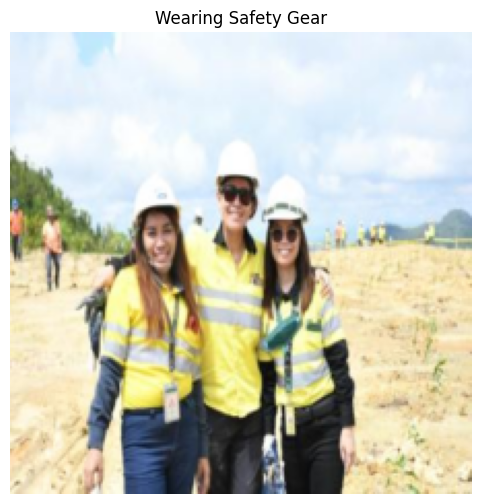

In [3]:
# visualizing a random image
random_idx = random.randint(0, len(dataset) - 1)
random_img, random_label = dataset[random_idx][0], dataset[random_idx][1]
img_permute = random_img.permute(1, 2, 0)

plt.figure(figsize=(8, 6))
plt.imshow(img_permute)
plt.axis("off")
plt.title(class_names[random_label]);

In [4]:
# train test split on our dataset
training_size = int(0.7 * len(dataset))
testing_size = len(dataset) - training_size

train_data, test_data = torch.utils.data.random_split(dataset, [training_size, testing_size])

print(f"images in training set: {len(train_data)}")
print(f"images in testing set: {len(test_data)}")
print(f"total images: {len(dataset)}")

images in training set: 248
images in testing set: 107
total images: 355


In [5]:
# creating dataloaders from train and test data
batch_size = 32

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=batch_size,
                              num_workers=1,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                              batch_size=batch_size,
                              num_workers=1,
                              shuffle=False)

In [6]:
# using a pretrained vit model
vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT
vit = torchvision.models.vit_b_16(weights=vit_weights).to(device)

# freeze the base parameters
for parameter in vit.parameters():
    parameter.requires_grad = False

# set number of classes
vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)

# print a summary using torchinfo 
summary(model=vit,
        input_size=(32, 3, 224, 224), 
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 2]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

In [7]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=0.0001,
                             betas=(0.9, 0.999),
                            weight_decay=0.2)

In [8]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
    """Trains a PyTorch model for a single epoch
    """
    model.train()

    train_loss, train_acc = 0, 0

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # 1. forward pass
        y_pred = model(X)

        # 2. calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # 3. optimizer zero grad
        optimizer.zero_grad()

        # 4. loss backward
        loss.backward()

        # 5. optimizer step
        optimizer.step()

        # calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [9]:
def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
    """tests a PyTorch model for a single epoch
    """
    # Put model in eval mode
    model.eval() 

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [10]:
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
    """trains and tests a PyTorch model with train_step() and test_step() 
    """
    # create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }
    
    # set model on device
    model.to(device)

    # training and testing loop
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        # print loss and accuracy
        print(
          f"epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # Return the filled results at the end of the epochs
    return results

In [ ]:
# trainig our model with train()
vit_results = train(model=vit,
                  train_dataloader=train_dataloader,
                  test_dataloader=test_dataloader,
                  optimizer=optimizer,
                  loss_fn=loss_fn,
                  epochs=20,
                  device=device)

  5%|▌         | 1/20 [10:57<3:28:18, 657.83s/it]

epoch: 1 | train_loss: 0.6300 | train_acc: 0.6693 | test_loss: 0.6159 | test_acc: 0.6364


 10%|█         | 2/20 [21:46<3:15:46, 652.57s/it]

epoch: 2 | train_loss: 0.5696 | train_acc: 0.7865 | test_loss: 0.5671 | test_acc: 0.7372


 15%|█▌        | 3/20 [36:01<3:31:06, 745.11s/it]

epoch: 3 | train_loss: 0.5253 | train_acc: 0.8203 | test_loss: 0.5254 | test_acc: 0.7678


 20%|██        | 4/20 [50:45<3:33:17, 799.84s/it]

epoch: 4 | train_loss: 0.4822 | train_acc: 0.8919 | test_loss: 0.4882 | test_acc: 0.8445


 25%|██▌       | 5/20 [1:02:26<3:11:01, 764.09s/it]

epoch: 5 | train_loss: 0.4469 | train_acc: 0.9062 | test_loss: 0.4542 | test_acc: 0.8991


 30%|███       | 6/20 [1:18:27<3:13:53, 831.00s/it]

epoch: 6 | train_loss: 0.4154 | train_acc: 0.9479 | test_loss: 0.4238 | test_acc: 0.9226


 30%|███       | 6/20 [1:24:41<3:17:36, 846.88s/it]


In [ ]:
def plot_loss_curves(results):
    """plots training curves of a results dictionary
    """
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    # loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

plot_loss_curves(vit_results)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to C:\Users\jacopo/.cache\torch\hub\checkpoints\vit_b_16-c867db91.pth


100.0%


VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [ ]:
# Get the actual class names from ImageNet (1000 classes)
class_labels = vit_weights.meta["categories"]  # This gives you all 1000 ImageNet classes

# Define preprocessing transform
preprocess = vit_weights.transforms()  # Use the model's native transforms
 
# Initialize webcam
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break
    
    # Convert frame to PIL Image
    pil_image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    
    # Preprocess image
    input_tensor = preprocess(pil_image)
    input_batch = input_tensor.unsqueeze(0).to(device)
    
    # Make prediction
    with torch.no_grad():
        output = vit(input_batch)
    
    # Get probabilities
    probabilities = torch.nn.functional.softmax(output[0], dim=0)
    
    # Get top prediction
    top1_prob, top1_catid = torch.topk(probabilities, 1)
    
    # Display prediction
    label = f"{class_labels[top1_catid[0]]} ({top1_prob[0].item():.2f})"
    
    # Check for hat-like classes (customize these based on ImageNet classes)
    hat_keywords = ['hat', 'cap', 'helmet', 'cowboy', 'sombrero']
    is_wearing_hat = any(keyword in class_labels[top1_catid[0]].lower() for keyword in hat_keywords)
    
    # Change color based on hat detection
    color = (0, 255, 0) if is_wearing_hat else (0, 0, 0)
    cv2.putText(frame, label, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)
    
    # Show frame
    cv2.imshow('Hat Detection', frame)
    
    # Exit on 'q' key
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

KeyboardInterrupt: 